# Apple Leaf and Fruit Diseases Classification Using DenseNet 121


Dataset credits: https://github.com/hsaleem1/NZDLPlantDisease-v1

Mount Google Drive

In [ ]:
#Mount google drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path ="/content/drive/MyDrive/Classroom/NewNZdataset"

DenseNet Training from scratch is among the best two models. External_test dataset is used in prediction after evaluating the model with test dataset.

In [ ]:
external_testing = "/content/drive/MyDrive/Classroom/External testing Dataset"

### Import all the Dependencies

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential, models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Model

### Set all the Constants

In [ ]:
BATCH_SIZE =64
IMAGE_SIZE = 224  #---“input shape has to be `(224, 224, 3)” → DenseNet121
CHANNELS=3
epochs=100
classes =7

### Import data into tensorflow dataset object

We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 15706 files belonging to 7 classes.


Loading External testing dataset to Test the best model

In [ ]:
external_test = tf.keras.preprocessing.image_dataset_from_directory(
    external_testing,
    seed=41,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 726 files belonging to 7 classes.


In [ ]:
#Print class names
class_names = dataset.class_names

class_names

['Black rot',
 'Black spot',
 'European Canker',
 'Healthy Fruit',
 'Healthy Leaf',
 'Leaf spot (scab)',
 'Mosaic virus ']

EXPLORATORY DATA ANALYSIS (EDA)

In [ ]:
#Total number of images ≈ Number of batches × Batch size
len(dataset)

246

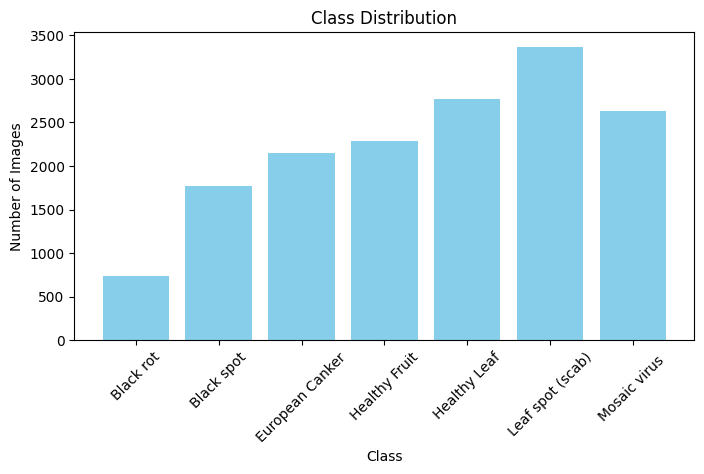

In [ ]:
# Count the number of images per class
class_counts = dict.fromkeys(class_names, 0)

for images, labels in dataset:
    for label in labels:
        label = int(label.numpy())  # Convert to int if necessary
        class_counts[class_names[label]] += 1

# Plotting the class distribution
plt.figure(figsize=(8, 4))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

Count the Element in Each Class

In [ ]:
import tensorflow as tf
from collections import defaultdict

class_counts = defaultdict(int)

# Iterate through the dataset to count occurrences of each class
for batch in dataset:
    # Extract labels from the batch
    labels = batch[1]

    # Count occurrences of each label in this batch
    for label in labels:
        class_counts[label.numpy()] += 1

# Display the counts for each class with class names
print("Class counts:")
for class_index, count in class_counts.items():
    class_name = class_names[class_index]
    print(f"{class_name}: {count} images")

Class counts:
Leaf spot (scab): 3368 images
European Canker: 2147 images
Healthy Leaf: 2765 images
Healthy Fruit: 2282 images
Mosaic virus : 2636 images
Black rot: 742 images
Black spot: 1766 images


# Defining Class Weights

There are many more observations of the Leaf spot class, and so this will have a larger impact on the overall value of the loss function than observations belonging to the other classes. the weight is going to be used for training the models

In [ ]:
# Example class counts (use your actual counts)
class_counts = {
    "Healthy Leaf": 2765,
    "Healthy Fruit": 2282,
    "Black spot": 1766,
    "European Canker": 2147,
    "Mosaic virus": 2636,
    "Leaf spot (scab)": 3368,
    "Black rot": 742,
}

# Total number of samples and unique classes
total_samples = sum(class_counts.values())
num_classes = len(class_counts)

# Calculate class weights
class_weights = {}
for i, (class_name, count) in enumerate(class_counts.items()):
    weight = total_samples / (num_classes * count)
    class_weights[i] = weight

In [ ]:
#Check the shape of the first batch
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 224, 224, 3)
(64,)


In [ ]:
for image_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[[1.69005112e+02 2.06719391e+02 6.97091904e+01]
   [1.58362228e+02 1.89790802e+02 8.76887665e+01]
   [8.69948959e+01 1.07234688e+02 5.43265305e+01]
   ...
   [2.49147964e+02 2.52122452e+02 1.97510239e+02]
   [2.51933701e+02 2.54147980e+02 2.05688828e+02]
   [2.54438812e+02 2.54714279e+02 2.14602173e+02]]

  [[1.51438782e+02 1.88954086e+02 5.46785736e+01]
   [1.63571426e+02 1.95045914e+02 9.24387741e+01]
   [1.18632652e+02 1.39418365e+02 8.27806091e+01]
   ...
   [2.51698959e+02 2.53989777e+02 1.96193863e+02]
   [2.50408157e+02 2.52193863e+02 2.00331665e+02]
   [2.50285721e+02 2.51857147e+02 2.04423523e+02]]

  [[1.41260208e+02 1.77714294e+02 4.91326523e+01]
   [1.60341843e+02 1.92061218e+02 8.86020432e+01]
   [1.27357132e+02 1.49285721e+02 8.58163223e+01]
   ...
   [2.49178543e+02 2.50306091e+02 1.89464279e+02]
   [2.49352051e+02 2.49846939e+02 1.92933701e+02]
   [2.52295975e+02 2.52653107e+02 2.00760330e+02]]

  ...

  [[7.85714035e+01 1.05571404e+02 5.45714073e+01]
   [7.71428375e+

As you can see above, each element in the dataset is a tuple. First element is a batch of 64 elements of images. Second element is a batch of 64 elements of class labels

### Visualize some of the images from our dataset

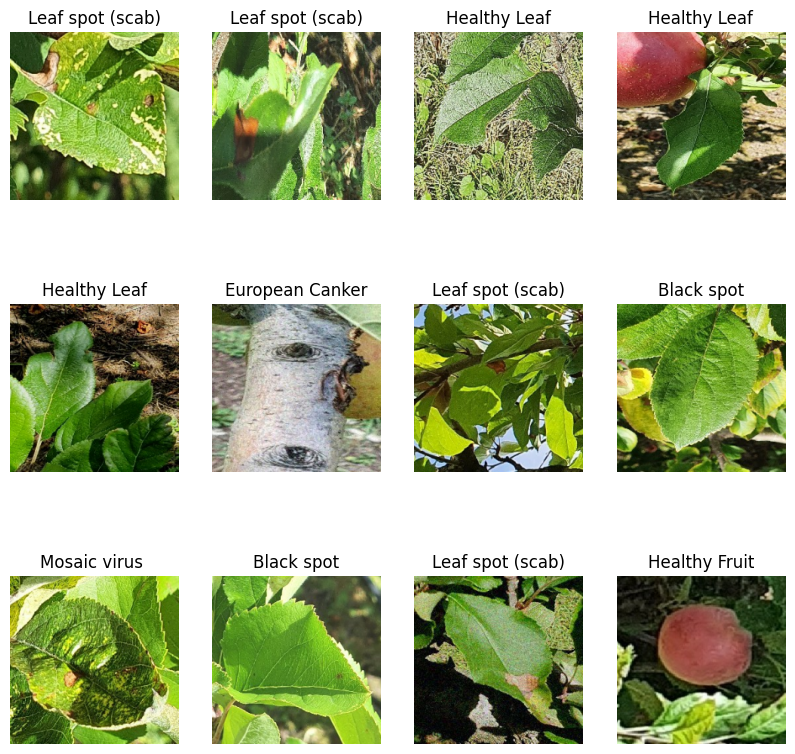

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [ ]:

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

172

In [ ]:
len(val_ds)

49

In [ ]:
len(test_ds)

25

### Cache, Shuffle, and Prefetch the Dataset

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
external_test = external_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Creating a Layer for Normalization
Creating a Layer for Normalization
Before we feed our images to network,  to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [ ]:
#normalization
rescale = tf.keras.Sequential([
layers.experimental.preprocessing.Rescaling(1./255),
])

## Building the Model

### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

# Training from Scratch

In [ ]:
from tensorflow.keras.layers import Input , BatchNormalization , ReLU , Conv2D , Dense , MaxPool2D , AvgPool2D , GlobalAvgPool2D , Concatenate
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model

In [ ]:
 def bat_relu_conv(x , filters , kernel_size) :
  x = BatchNormalization()(x)
  x = ReLU()(x)
  x = Conv2D(filters=filters , kernel_size=kernel_size , padding="same")(x)
  return x

In [ ]:
def Dense_block(tensor , k , reps):
  for _ in range(reps):
    x = bat_relu_conv(tensor , filters=4*k , kernel_size=1)
    x = bat_relu_conv(x , filters=k , kernel_size=3)
    tensor = Concatenate()([tensor , x])
  return tensor

In [ ]:
def transition_layer(x , theta=0.5):
  #  (0 < theta <= 1) if a dense block contains M feature-maps ,
  #  we let the following transition layer generate (thete of M) output feature-maps
  f = int(tf.keras.backend.int_shape(x)[-1] * theta)
  x = bat_relu_conv(x , filters=f , kernel_size=1)
  x = AvgPool2D(2 , strides=2 , padding="same")(x)
  return x

In [ ]:
k = 32
REPETITIONS = 6,12,24,16
INPUT_SHAPE = (224,224,3)
input = Input(shape=INPUT_SHAPE)

# Input layer with normalization
input = Input(shape=INPUT_SHAPE)
input = rescale(input)  # Apply normalization

# the top of our model
x = Conv2D(filters=2*k , kernel_size=7 , strides=2 , padding="same")(input)
x = MaxPool2D(pool_size=3 , strides=2 , padding="same")(x)
# the main model


for reps in REPETITIONS:
  d = Dense_block(x ,k=k,  reps=reps)
  x = transition_layer(d , theta=0.5)


# the tail model
x = GlobalAvgPool2D()(d) # apply the GlobalAvgPool2D to the output of the dense layer
output = Dense(classes, activation="softmax")(x)


model = Model(input , output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 112, 112, 64)         9472      ['input_3[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)           0         ['conv2d[1][0]']              
 D)                                                                                               
                                                                                                  
 batch_normalization (Batch  (None, 56, 56, 64)           256       ['max_pooling2d[1][0]']   

# Defining Callbacks

A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

In [ ]:
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),  # Factor to reduce learning rate
    patience=5,
    verbose=1
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs to wait before stopping
    verbose=1,
    restore_best_weights=True
)

Defining the Optimizer

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

In [ ]:
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=epochs,
    class_weight = class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
172/172 - 180s - loss: 1.3174 - accuracy: 0.5530 - val_loss: 2.3987 - val_accuracy: 0.4091 - lr: 0.0010 - 180s/epoch - 1s/step
Epoch 2/100
172/172 - 42s - loss: 0.8639 - accuracy: 0.6695 - val_loss: 10.2285 - val_accuracy: 0.2643 - lr: 0.0010 - 42s/epoch - 246ms/step
Epoch 3/100
172/172 - 42s - loss: 0.7282 - accuracy: 0.7103 - val_loss: 36.6519 - val_accuracy: 0.2325 - lr: 0.0010 - 42s/epoch - 245ms/step
Epoch 4/100
172/172 - 42s - loss: 0.6257 - accuracy: 0.7464 - val_loss: 0.9330 - val_accuracy: 0.6722 - lr: 0.0010 - 42s/epoch - 247ms/step
Epoch 5/100
172/172 - 42s - loss: 0.4912 - accuracy: 0.8096 - val_loss: 0.6011 - val_accuracy: 0.7631 - lr: 0.0010 - 42s/epoch - 247ms/step
Epoch 6/100
172/172 - 42s - loss: 0.3981 - accuracy: 0.8507 - val_loss: 0.3603 - val_accuracy: 0.8594 - lr: 0.0010 - 42s/epoch - 247ms/step
Epoch 7/100
172/172 - 42s - loss: 0.3393 - accuracy: 0.8791 - val_loss: 0.6785 - val_accuracy: 0.7886 - lr: 0.0010 - 42s/epoch - 245ms/step
Epoch 8/100
172/172

Evaluate the test_ds

In [ ]:
scores = model.evaluate(test_ds)

25/25 [==============================] - 30s 143ms/step - loss: 0.0400 - accuracy: 0.9846


Evaluating the external test dataset

In [ ]:
external_scores = model.evaluate(external_test)

12/12 [==============================] - 40s 203ms/step - loss: 3.5800 - accuracy: 0.5592


Make prediction on a random image from test_ds

first image to predict
actual label: Healthy Leaf
2/2 [==============================] - 0s 52ms/step
predicted label: Healthy Leaf


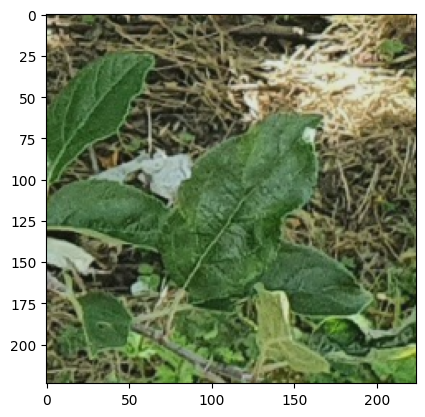

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

Plotting training and validation accuracy, loss and learning rate

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

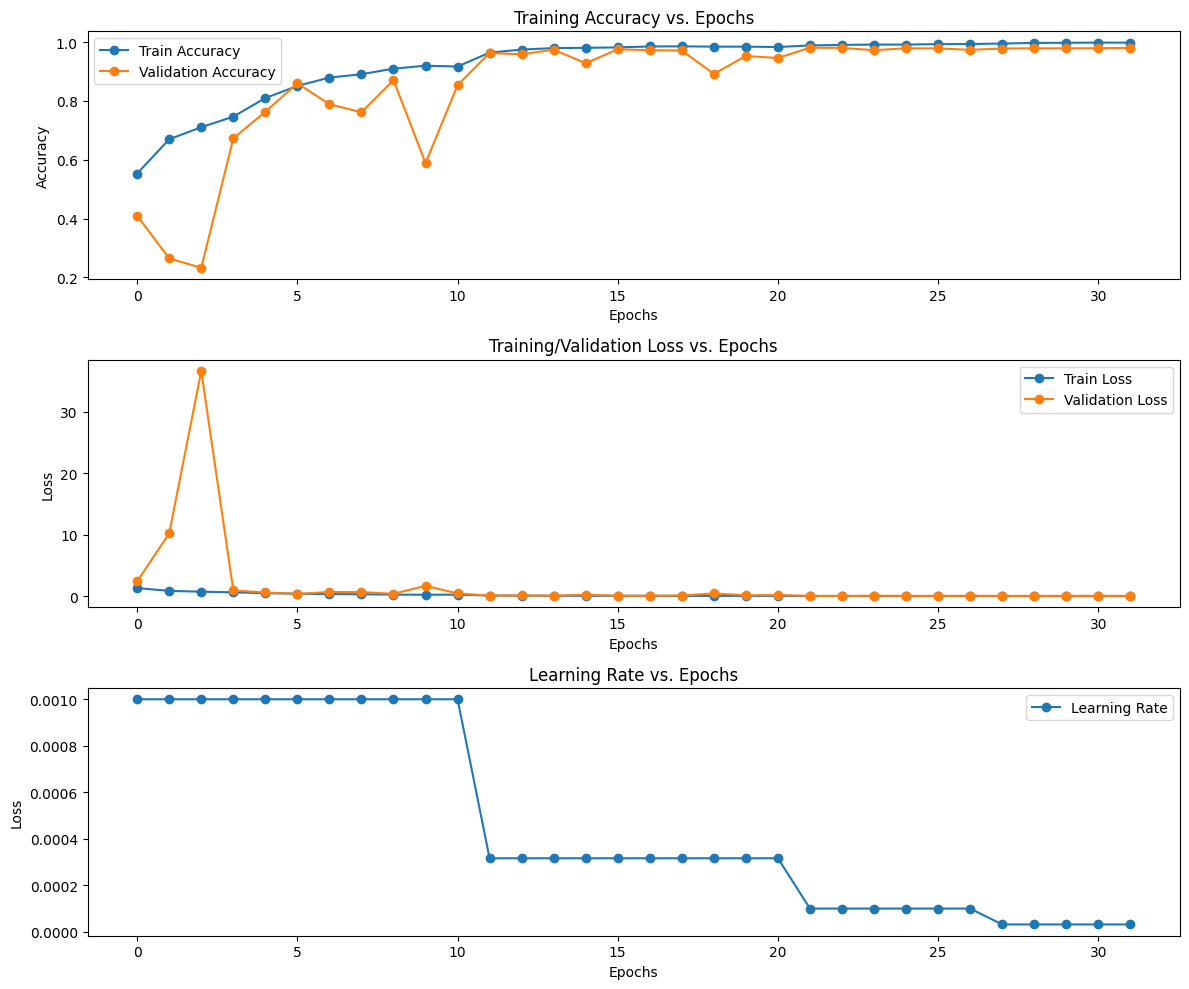

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

Confusion Matrix

2/2 [==============================] - 0s 37ms/step


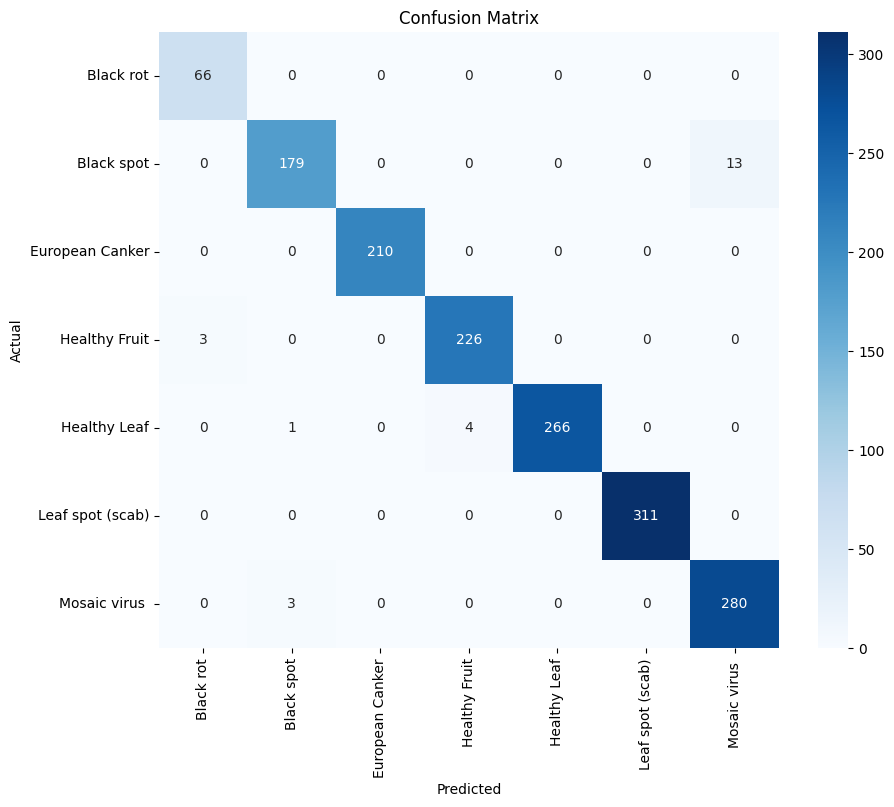

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted classes

# Confusion Matrix with class names
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


Classification Report with Precision and Recall

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)

Classification Report:
                   precision    recall  f1-score   support

       Black rot       0.96      1.00      0.98        66
      Black spot       0.98      0.93      0.95       192
 European Canker       1.00      1.00      1.00       210
   Healthy Fruit       0.98      0.99      0.98       229
    Healthy Leaf       1.00      0.98      0.99       271
Leaf spot (scab)       1.00      1.00      1.00       311
   Mosaic virus        0.96      0.99      0.97       283

        accuracy                           0.98      1562
       macro avg       0.98      0.98      0.98      1562
    weighted avg       0.98      0.98      0.98      1562



ROC AUC

2/2 [==============================] - 0s 36ms/step


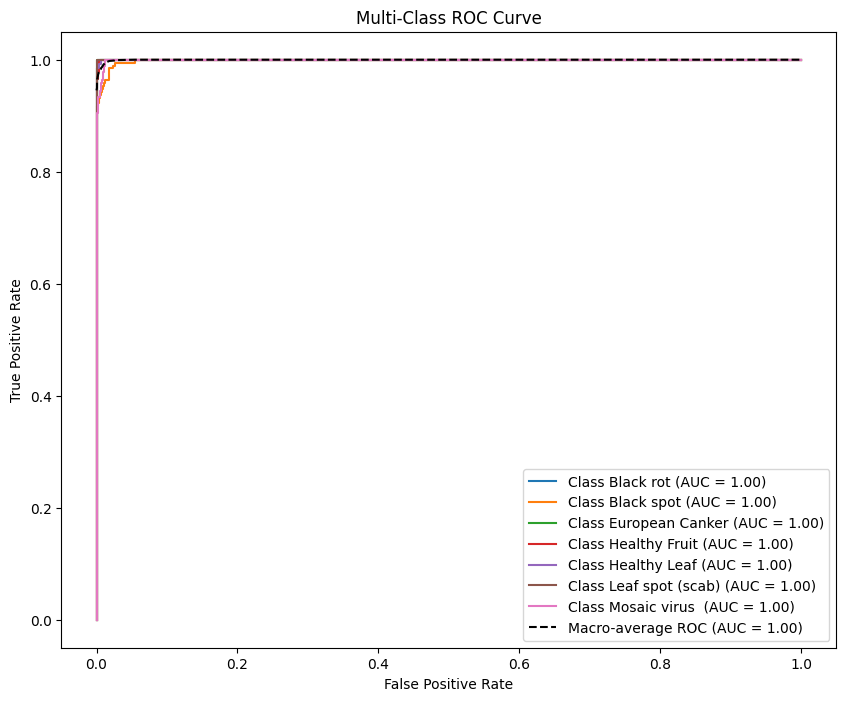

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions (probabilities)
    y_pred_probs.extend(predictions)  # Collect predicted probabilities

# Convert to NumPy arrays
y_true = np.array(y_true)  # Ensure true labels are arrays
y_pred_probs = np.array(y_pred_probs)  # Ensure predicted probabilities are arrays

# Binarize the true labels to get a one-hot encoded representation
y_true_bin = label_binarize(y_true, classes=list(range(20)))

# Initialize ROC and AUC data
fpr = dict()  # False positive rates
tpr = dict()  # True positive rates
roc_auc = dict()  # AUC for each class

# Compute ROC and AUC for each class
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # ROC data for each class
    roc_auc[i] = auc(fpr[i], tpr[i])  # AUC for each class

# Compute macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
mean_tpr = np.zeros_like(all_fpr)

# Compute mean true positive rates
for i in range(classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= classes  # Normalize by the number of classes
macro_auc = auc(all_fpr, mean_tpr)  # Macro-average AUC

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')  # Label with class names and AUC

# Plot the macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='k', linestyle='--', label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

Classification Report on External Dataset

In [ ]:
# Get true and predicted labels
y_true_external = []
y_pred_external = []

for images, labels in external_test:
    y_true_external.extend(labels.numpy())  # Collect true labels
    predictions = model.predict(images)  # Get model predictions
    y_pred_external.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted classes




report = classification_report(y_true_external, y_pred_external, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)

2/2 [==============================] - 0s 37ms/step
Classification Report:
                   precision    recall  f1-score   support

       Black rot       0.28      0.36      0.31        42
      Black spot       0.38      0.57      0.46       120
 European Canker       0.50      0.99      0.66        72
   Healthy Fruit       0.65      0.57      0.60        90
    Healthy Leaf       0.48      0.23      0.31       126
Leaf spot (scab)       0.35      0.17      0.23        54
   Mosaic virus        0.89      0.73      0.80       222

        accuracy                           0.56       726
       macro avg       0.50      0.52      0.48       726
    weighted avg       0.59      0.56      0.55       726



In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in external_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

# Transfer Learning

In [ ]:
from keras.applications import DenseNet121

In [ ]:
from keras.layers import Input,Rescaling

# this could also be the output a different Keras model or layer
input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = rescale(input)

In [ ]:
# Load the dense pre-trained model without the top layer (fully connected layers)
dense =DenseNet121(input_tensor=x, weights='imagenet', include_top=False)

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Freeze the layers of dense
for layer in dense.layers:
  layer.trainable =False




In [ ]:
x = GlobalAveragePooling2D()(dense.output)
prediction = Dense(classes, activation ='softmax')(x)
#create a model object
model_tl =Model(inputs =dense.input, outputs =prediction)
#View the structure of the model
model_tl.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 224, 224, 3)          0         ['input_5[0][0]']             
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 230, 230, 3)          0         ['sequential[2][0]']          
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d[0][0]']

In [ ]:
#Define Callback

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),  # Factor to reduce learning rate
    patience=5,
    verbose=1
)

# Callback to stop training when validation loss doesn't improve
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Number of epochs to wait before stopping
    verbose=1,
    restore_best_weights=True
)

In [ ]:
#Define the optimizer
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [ ]:
model_tl.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model_tl.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=2,
    epochs=epochs,
    class_weight = class_weights,
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/100
172/172 - 32s - loss: 1.0153 - accuracy: 0.6403 - val_loss: 0.6311 - val_accuracy: 0.7707 - lr: 0.0010 - 32s/epoch - 189ms/step
Epoch 2/100
172/172 - 24s - loss: 0.5373 - accuracy: 0.8109 - val_loss: 0.4542 - val_accuracy: 0.8473 - lr: 0.0010 - 24s/epoch - 142ms/step
Epoch 3/100
172/172 - 24s - loss: 0.4291 - accuracy: 0.8546 - val_loss: 0.3959 - val_accuracy: 0.8619 - lr: 0.0010 - 24s/epoch - 141ms/step
Epoch 4/100
172/172 - 24s - loss: 0.3709 - accuracy: 0.8714 - val_loss: 0.3497 - val_accuracy: 0.8804 - lr: 0.0010 - 24s/epoch - 141ms/step
Epoch 5/100
172/172 - 24s - loss: 0.3299 - accuracy: 0.8879 - val_loss: 0.3325 - val_accuracy: 0.8900 - lr: 0.0010 - 24s/epoch - 141ms/step
Epoch 6/100
172/172 - 24s - loss: 0.3025 - accuracy: 0.8961 - val_loss: 0.2904 - val_accuracy: 0.9040 - lr: 0.0010 - 24s/epoch - 142ms/step
Epoch 7/100
172/172 - 24s - loss: 0.2788 - accuracy: 0.9046 - val_loss: 0.2899 - val_accuracy: 0.9059 - lr: 0.0010 - 24s/epoch - 141ms/step
Epoch 8/100
172/172 

Evaluate the model

In [ ]:
scores = model_tl.evaluate(test_ds)

25/25 [==============================] - 3s 113ms/step - loss: 0.1334 - accuracy: 0.9609


### Run prediction on a sample image

first image to predict
actual label: Healthy Fruit
2/2 [==============================] - 2s 53ms/step
predicted label: Healthy Fruit


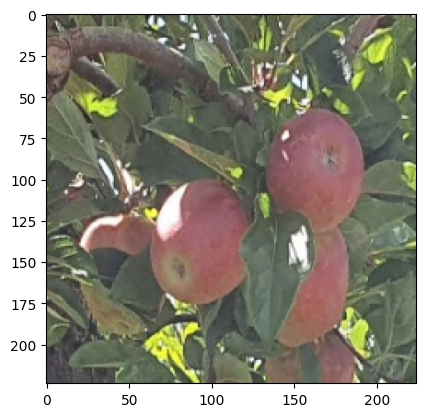

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model_tl.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

# Plotting the accuracy, loss and the epoch curves

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

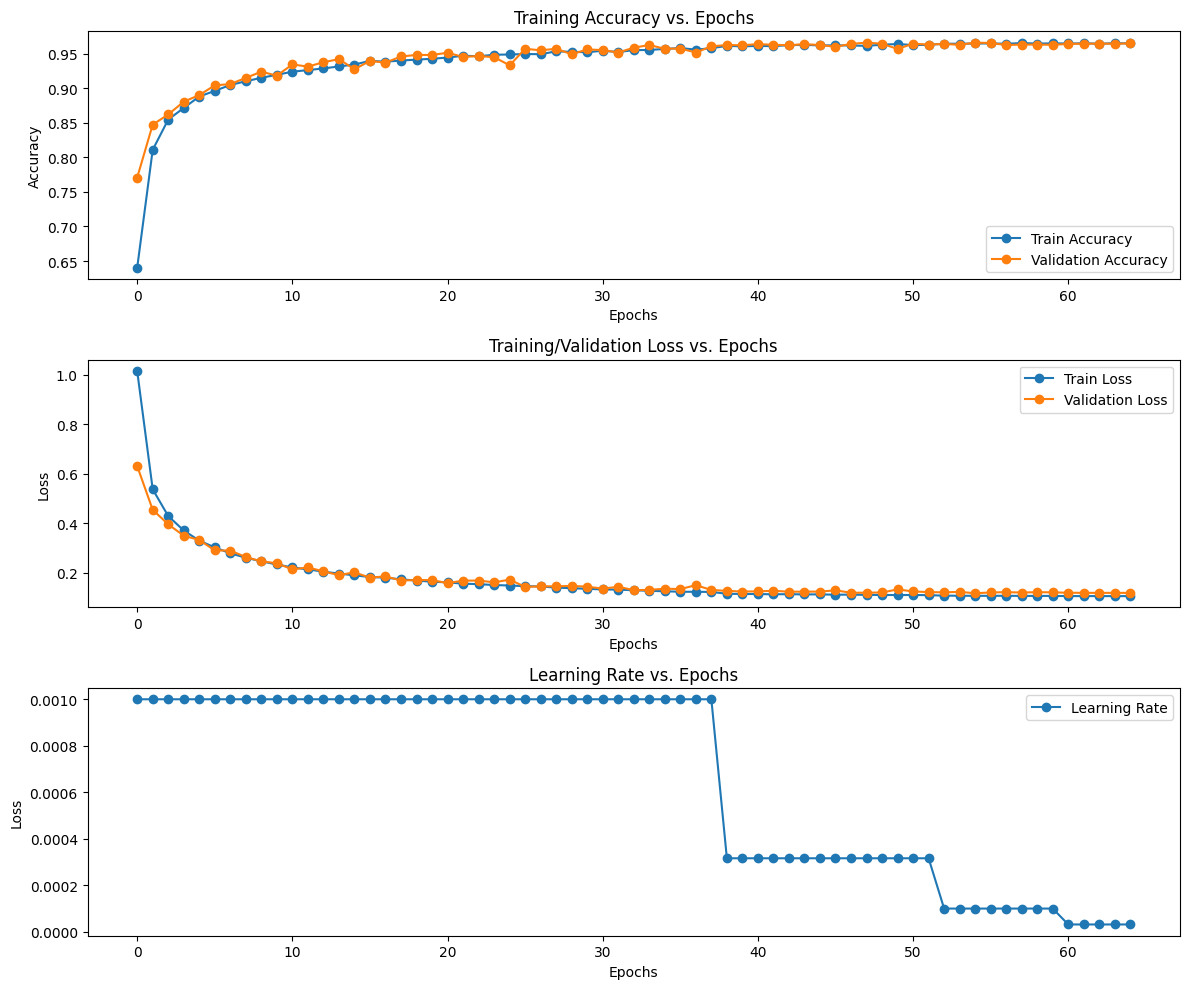

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()

Confusion matrix

2/2 [==============================] - 0s 48ms/step


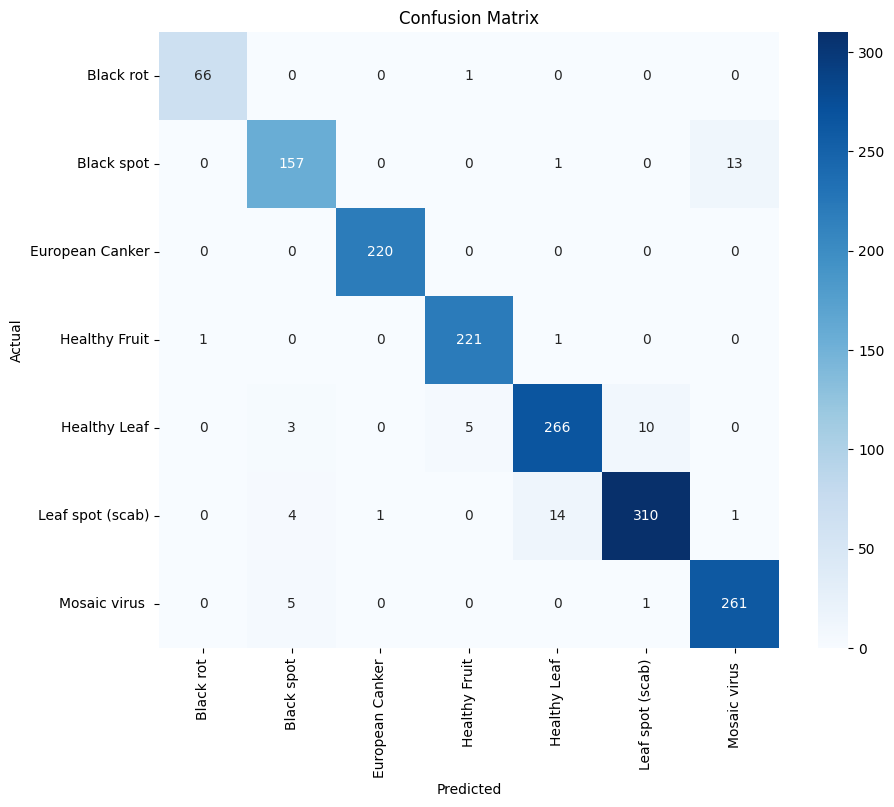

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np



# Get true and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model_tl.predict(images)  # Get model predictions
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())  # Get predicted classes

# Confusion Matrix with class names
cf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt="g", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Classification Report

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=class_names, zero_division=1)
print("Classification Report:\n", report)

Classification Report:
                   precision    recall  f1-score   support

       Black rot       0.99      0.99      0.99        67
      Black spot       0.93      0.92      0.92       171
 European Canker       1.00      1.00      1.00       220
   Healthy Fruit       0.97      0.99      0.98       223
    Healthy Leaf       0.94      0.94      0.94       284
Leaf spot (scab)       0.97      0.94      0.95       330
   Mosaic virus        0.95      0.98      0.96       267

        accuracy                           0.96      1562
       macro avg       0.96      0.96      0.96      1562
    weighted avg       0.96      0.96      0.96      1562



ROC - AUC

2/2 [==============================] - 0s 49ms/step


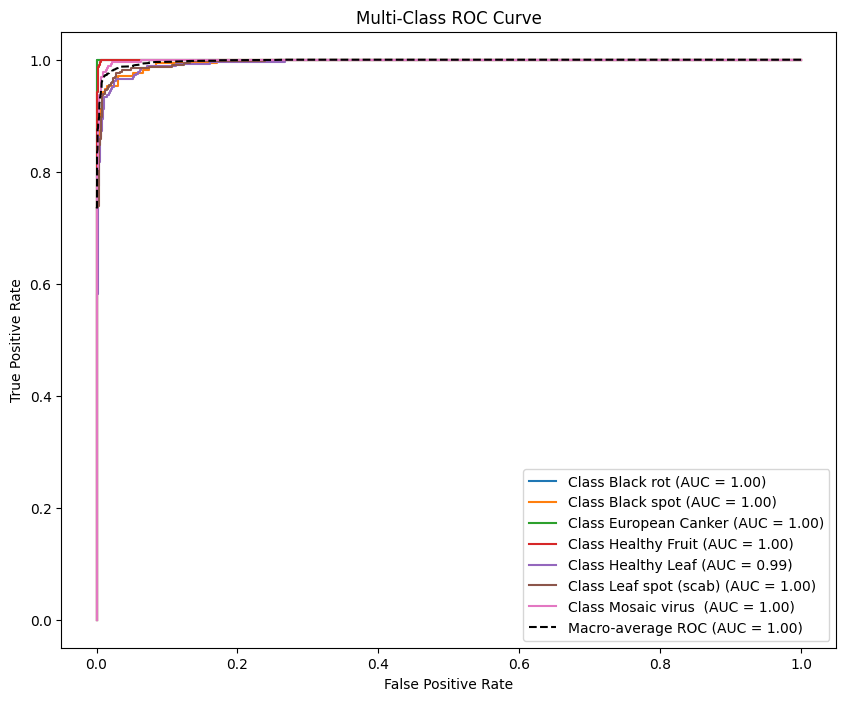

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true = []
y_pred_probs = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Collect true labels
    predictions = model_tl.predict(images)  # Get model predictions (probabilities)
    y_pred_probs.extend(predictions)  # Collect predicted probabilities

# Convert to NumPy arrays
y_true = np.array(y_true)  # Ensure true labels are arrays
y_pred_probs = np.array(y_pred_probs)  # Ensure predicted probabilities are arrays

# Binarize the true labels to get a one-hot encoded representation
y_true_bin = label_binarize(y_true, classes=list(range(20)))

# Initialize ROC and AUC data
fpr = dict()  # False positive rates
tpr = dict()  # True positive rates
roc_auc = dict()  # AUC for each class

# Compute ROC and AUC for each class
for i in range(classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])  # ROC data for each class
    roc_auc[i] = auc(fpr[i], tpr[i])  # AUC for each class

# Compute macro-average AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))
mean_tpr = np.zeros_like(all_fpr)

# Compute mean true positive rates
for i in range(classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= classes  # Normalize by the number of classes
macro_auc = auc(all_fpr, mean_tpr)  # Macro-average AUC

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {class_names[i]} (AUC = {roc_auc[i]:.2f})')  # Label with class names and AUC

# Plot the macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='k', linestyle='--', label=f'Macro-average ROC (AUC = {macro_auc:.2f})')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()

Write a function for inference for the better model -

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images from the traing from scratch model**

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.